<a href="https://colab.research.google.com/github/sominshim/Predicting_Personality_through_Text/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# !pip install tensorflow-hub
# !pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  2.3.0
즉시 실행 모드:  True
허브 버전:  0.10.0
GPU 사용 가능


In [2]:
# import module
import io
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.random.seed(42)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [4]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/mbti_1.csv'

In [6]:
#pandas read_csv로 불러오기
data = pd.read_csv(filename)
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


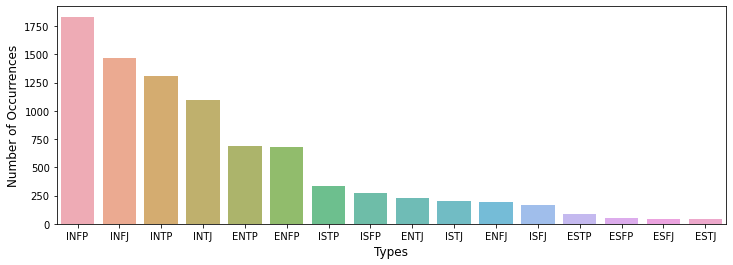

In [7]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [8]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [9]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'E':0, 'I':1, 'S':0, 'N':1, 'T':0, 'F':1, 'J':0, 'P':1}
b_Pers_list = [{0:'E', 1:'I'}, {0:'S', 1:'N'}, {0:'T', 1:'F'}, {0:'J', 1:'P'}]

#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 1 0]
 [0 1 0 1]
 [1 1 0 1]
 ...
 [1 1 0 1]
 [1 1 1 1]
 [1 1 1 1]]


In [10]:
data['E-I'] = list_personality_bin[:,0]
data['S-N'] = list_personality_bin[:,1]
data['T-F'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [11]:
data.head()

,type,posts,E-I,S-N,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0


In [12]:
data.shape

(8675, 6)

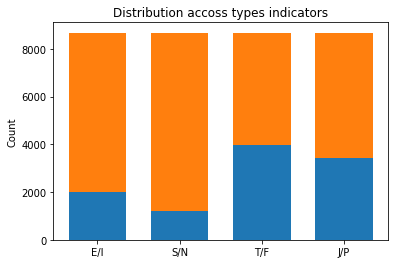

In [13]:
N = 4
but = (data['E-I'].value_counts()[0], data['S-N'].value_counts()[0], data['T-F'].value_counts()[0], data['J-P'].value_counts()[0])
top = (data['E-I'].value_counts()[1], data['S-N'].value_counts()[1], data['T-F'].value_counts()[1], data['J-P'].value_counts()[1])

ind = np.arange(N)    
width = 0.7      

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('E/I',  'S/N', 'T/F', 'J/P',))

plt.show()

In [14]:
print ("Introversion (I) /  Extroversion (E):\t", data['E-I'].value_counts()[0], " / ", data['E-I'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['S-N'].value_counts()[0], " / ", data['S-N'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", data['T-F'].value_counts()[0], " / ", data['T-F'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", data['J-P'].value_counts()[0], " / ", data['J-P'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Thinking (T) – Feeling (F):		 3981  /  4694
Judging (J) – Perceiving (P):		 3434  /  5241


## 데이터 전처리

In [15]:
from sklearn.preprocessing import LabelBinarizer
import re
import string

In [16]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'I\'m', 'I am'),(r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

text_replace = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_replace['TextBefore'] = data['posts'].copy()

In [17]:
for index, row in text_replace.iterrows():
    row['TextAfter'] = replace(row['TextBefore'])

In [18]:
print(text_replace['TextBefore'][:5],'\n->\n', text_replace['TextAfter'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: TextBefore, dtype: object 
->
 0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object


### 특수문자 제거

In [19]:
def cleaner(post):
    # 소문자 변환
    post = post.lower() 
    
    # '|||' 제거
    post = post.replace('|||', "") 

    # URL, 링크 등 특수문자 제거
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 

    # 구두점 제거
    post = post.translate(str.maketrans('', '', string.punctuation))

    # 공백 제거
    post = re.sub( '\s+', ' ', post ).strip()

    # MBTI 제거
    post = re.sub('infj|entp|intp|intj|entj|enfj|infp|enfp|isfp|istp|isfj|istj|estp|esfp|estj|esfj',"", post)

    # 길이가 짧은 단어 제거
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    post = shortword.sub('', post)
    
    return post

In [20]:
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
data['clean_post'] = posts

In [21]:
print(text_replace['TextAfter'][:5],'\n->\n', data['clean_post'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object 
->
 0    and  moments sportscenter not top ten plays pr...
1     finding the lack these posts very alarmingsex...
2    good one course which say know that blessing a...
3    dear enjoyed our conversation the other day es...
4    you are firedthat another silly misconception ...
Name: clean_post, dtype: object


### Remove Stopwords


In [22]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

n=WordNetLemmatizer()
s = PorterStemmer()

def tokenize(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    lem  = [n.lemmatize(w) for w in finalTokens]
    stem = [s.stem(w) for w in lem]
    text = " ".join(stem)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
text_removeStopwords = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_removeStopwords['TextBefore'] = data['clean_post'].copy()


In [24]:
nltk.download('punkt')
for index, row in text_removeStopwords.iterrows():
    row['TextAfter'] = tokenize(row['TextBefore'])

data['clean_post'] = text_removeStopwords['TextAfter']
print(data['clean_post'][:5],'\n->\n',text_removeStopwords['TextAfter'][:5])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object 
->
 0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: TextAfter, dtype: object


### Most frequent mispells -> Correct manually 



In [25]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [26]:
data['clean_post'] = data['clean_post'].apply(lambda x: correct_spelling(x, mispell_dict))
data['clean_post'][:5]

0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object

## Train/ Test/ Validation data Split

계층적으로 분리

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    train = data.loc[train_index]
    test = data.loc[test_index]

In [28]:
train.head()

,type,posts,E-I,S-N,T-F,J-P,clean_post
1228,INFP,'We are mandarin speakers. He receive educati...,1,1,1,1,mandarin speaker receiv educ canada sinc 13tha...
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",1,0,0,1,nope ever busi work caus adrenalinerush activ ...
6756,ENFJ,'That's the only one I haven't gotten to read ...,0,1,1,0,one gotten read yet might pick one bookstoreso...
1662,INFP,'I used to think that maturity was burning bri...,1,1,1,1,use think matur burn bridg without second thou...
3338,INFP,'I get typed as both a 4w5 and 5w6 as well but...,1,1,1,1,get type 4w5 5w6 well like consid 4w5 fit perf...


## OverSampling


In [29]:
le = LabelEncoder()
result = le.fit_transform(train['type'])
print(result)

[ 9 15  0 ...  2 11  3]


In [30]:
train['type_n'] = result

In [31]:
train.head()

,type,posts,E-I,S-N,T-F,J-P,clean_post,type_n
1228,INFP,'We are mandarin speakers. He receive educati...,1,1,1,1,mandarin speaker receiv educ canada sinc 13tha...,9
1290,ISTP,"'Nope. Not now, not ever. I'm too busy with ...",1,0,0,1,nope ever busi work caus adrenalinerush activ ...,15
6756,ENFJ,'That's the only one I haven't gotten to read ...,0,1,1,0,one gotten read yet might pick one bookstoreso...,0
1662,INFP,'I used to think that maturity was burning bri...,1,1,1,1,use think matur burn bridg without second thou...,9
3338,INFP,'I get typed as both a 4w5 and 5w6 as well but...,1,1,1,1,get type 4w5 5w6 well like consid 4w5 fit perf...,9


In [32]:
from collections import Counter
from matplotlib import pyplot

# 필요 함수 정의
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

In [33]:
values = train[['clean_post', 'type', 'type_n']].values
X, y = values[:, :-1], values[:, -1]

Class=9, n=1465 (21.110%)
Class=15, n=270 (3.890%)
Class=0, n=152 (2.190%)
Class=1, n=540 (7.781%)
Class=8, n=1176 (16.945%)
Class=5, n=38 (0.548%)
Class=10, n=873 (12.579%)
Class=13, n=217 (3.127%)
Class=14, n=164 (2.363%)
Class=3, n=548 (7.896%)
Class=2, n=185 (2.666%)
Class=11, n=1043 (15.029%)
Class=12, n=133 (1.916%)
Class=7, n=71 (1.023%)
Class=4, n=34 (0.490%)
Class=6, n=31 (0.447%)


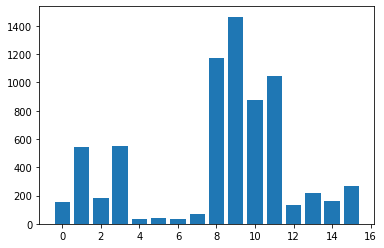

In [34]:
count_and_plot(y)

Class=9, n=1465 (6.250%)
Class=15, n=1465 (6.250%)
Class=0, n=1465 (6.250%)
Class=1, n=1465 (6.250%)
Class=8, n=1465 (6.250%)
Class=5, n=1465 (6.250%)
Class=10, n=1465 (6.250%)
Class=13, n=1465 (6.250%)
Class=14, n=1465 (6.250%)
Class=3, n=1465 (6.250%)
Class=2, n=1465 (6.250%)
Class=11, n=1465 (6.250%)
Class=12, n=1465 (6.250%)
Class=7, n=1465 (6.250%)
Class=4, n=1465 (6.250%)
Class=6, n=1465 (6.250%)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/usr/local/lib/python3.6/dist-packages/s

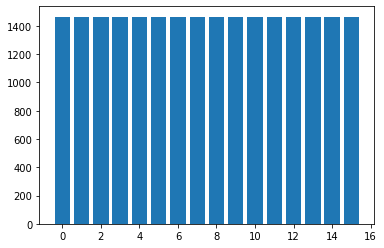

In [35]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(X, y)
count_and_plot(y_resampled)

In [36]:
train = pd.DataFrame({'clean_post': X_resampled[:, 0], 'type': X_resampled[:, 1]})
train.shape

(23440, 2)

In [37]:
train.head()

,clean_post,type
0,mandarin speaker receiv educ canada sinc 13tha...,INFP
1,nope ever busi work caus adrenalinerush activ ...,ISTP
2,one gotten read yet might pick one bookstoreso...,ENFJ
3,use think matur burn bridg without second thou...,INFP
4,get type 4w5 5w6 well like consid 4w5 fit perf...,INFP


In [38]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train.head()

,clean_post,type
0,alway think cat dom reason websit becom neo na...,ISFP
1,dear xsxx peopl numer much mindless chatterx85...,ENTJ
2,masculin necessarili walk purpos transit march...,ISTP
3,person challeng like pick charact differ style...,ESTJ
4,mean sure want marri hurri chang want togeth a...,ESFJ


In [39]:
list_personality_bin = np.array([translate_personality(p) for p in train.type])

train['E-I'] = list_personality_bin[:,0]
train['S-N'] = list_personality_bin[:,1]
train['T-F'] = list_personality_bin[:,2]
train['J-P'] = list_personality_bin[:,3]

In [40]:
X_train = train.clean_post
X_test = test.clean_post
y_train = list_personality_bin[X_train.index]
y_test = list_personality_bin[X_test.index]

In [41]:
train.head()

,clean_post,type,E-I,S-N,T-F,J-P
0,alway think cat dom reason websit becom neo na...,ISFP,1,0,1,1
1,dear xsxx peopl numer much mindless chatterx85...,ENTJ,0,1,0,0
2,masculin necessarili walk purpos transit march...,ISTP,1,0,0,1
3,person challeng like pick charact differ style...,ESTJ,0,0,0,0
4,mean sure want marri hurri chang want togeth a...,ESFJ,0,0,1,0


- average = micro는 총 참 양성, 거짓 음성 및 거짓 양성을 고려하여 f1을 계산하는 함수를 말합니다 (데이터 세트의 각 레이블에 대한 예측에 관계없이).
- average = macro는 각 레이블에 대해 f1을 계산하는 함수를 말하고 데이터 세트의 각 레이블에 대한 비율을 고려하지 않고 평균을 반환합니다.
- average = weighted는 각 레이블에 대해 f1을 계산하는 함수를 말하고 데이터 세트의 각 레이블에 대한 비율을 고려하여 평균을 반환합니다.
- average = samples는 각 인스턴스에 대해 f1을 계산하는 함수를 말하고 평균을 반환합니다. 다중 레이블 분류에 사용하십시오.



## 모델 훈련


In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve

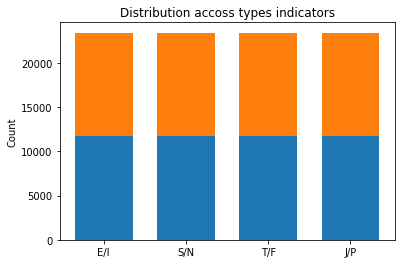

In [44]:
N = 4
but = (train['E-I'].value_counts()[0], train['S-N'].value_counts()[0], train['T-F'].value_counts()[0], train['J-P'].value_counts()[0])
top = (train['E-I'].value_counts()[1], train['S-N'].value_counts()[1], train['T-F'].value_counts()[1], train['J-P'].value_counts()[1])

ind = np.arange(N)    
width = 0.7      

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('E/I',  'S/N', 'T/F', 'J/P',))

plt.show()

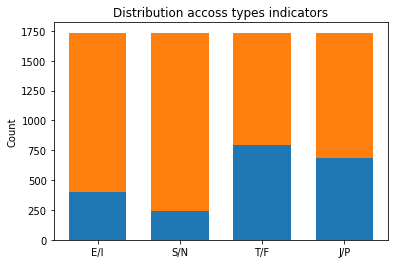

In [45]:
N = 4
but = (test['E-I'].value_counts()[0], test['S-N'].value_counts()[0], test['T-F'].value_counts()[0], test['J-P'].value_counts()[0])
top = (test['E-I'].value_counts()[1], test['S-N'].value_counts()[1], test['T-F'].value_counts()[1], test['J-P'].value_counts()[1])

ind = np.arange(N)    
width = 0.7      

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('E/I',  'S/N', 'T/F', 'J/P',))

plt.show()

In [46]:
categories = ['E-I', 'S-N', 'T-F', 'J-P']

... Processing E-I
0.8748293515358362 0.7302593659942364
f1_score is 0.8220532319391635
[[ 186  214]
 [ 254 1081]]
              precision    recall  f1-score   support

           0       0.42      0.47      0.44       400
           1       0.83      0.81      0.82      1335

    accuracy                           0.73      1735
   macro avg       0.63      0.64      0.63      1735
weighted avg       0.74      0.73      0.73      1735

... Processing S-N
0.8967150170648465 0.7873198847262248
f1_score is 0.8737598357851523
[[  89  150]
 [ 219 1277]]
              precision    recall  f1-score   support

           0       0.29      0.37      0.33       239
           1       0.89      0.85      0.87      1496

    accuracy                           0.79      1735
   macro avg       0.59      0.61      0.60      1735
weighted avg       0.81      0.79      0.80      1735

... Processing T-F
0.8997866894197952 0.7487031700288185
f1_score is 0.7566964285714287
[[621 175]
 [261 678]]
     

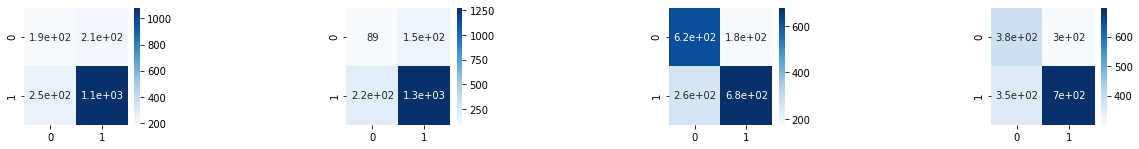

Average f1-score of LinearSVC :  0.7835375303239361


In [49]:
import seaborn as sns
from matplotlib import gridspec
from sklearn.model_selection import StratifiedKFold

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(C=0.01), n_jobs=1))
])

total_f1_score = 0

fig = plt.figure(figsize=(18, 16)) 
gs = gridspec.GridSpec(8,8 ) 
n=0

for category in categories:
    print('... Processing {}'.format(category))

    model = SVC_pipeline.fit(X_train, train[category])
    prediction = model.predict(X_test)
    scoreTrain = model.score(X_train, train[category])
    scoreTest = model.score(X_test, test[category])
    print(scoreTrain, scoreTest)

    f1_score_ = f1_score(test[category], prediction)
    total_f1_score += f1_score_
    print('f1_score is {}'.format(f1_score_))

    cf_matrix = confusion_matrix(test[category], prediction)
    print(cf_matrix)
    print(classification_report(test[category], prediction))

    # labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    # labels = np.asarray(labels).reshape(2,2)
    plt.subplot(gs[n*2+0])
    sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    n+=1
    # fpr, tpr, thresholds = roc_curve(train[category], SVC_pipeline.predict_proba(X_train)[:, 1])
    # plt.plot(fpr, tpr, '-', label=category)

# plt.plot([0, 1], [0, 1], 'k--', label="random guess")
# plt.legend(fontsize = 8)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('MultinomialNB ROC Curve')
# plt.show()

plt.tight_layout()  # 창 크기에 맞게 조정
plt.show()
print('Average f1-score of LinearSVC : ', total_f1_score/4)
# print('Average precision of LinearSVC : ', total_precision/4)
# print('Average recall of LinearSVC : ', total_recall/4)

In [ ]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
total_score = 0
acc =0
for category in categories:
    print('... Processing {}'.format(category))

    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='macro')
    total_score += score
    print('f1_score is {}'.format(score))
    acc += accuracy_score(test[category], prediction)
    print('accuracy is {}'.format(accuracy_score(test[category], prediction)))

    print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels = np.asarray(labels).reshape(2,2)
    # sns.heatmap(cf_matrix, annot=labels, fmt=‘’, cmap='Blues')
#     fpr, tpr, thresholds = roc_curve(train[category], NB_pipeline.predict_proba(X_train)[:, 1])
#     plt.plot(fpr, tpr, '-', label=category)

# plt.plot([0, 1], [0, 1], 'k--', label="random guess")
# plt.legend(fontsize = 8)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('MultinomialNB ROC Curve')
# plt.show()

print('Average f1-score of MultinomialNB : ', total_score/4)
print('Average accuracy of MultinomialNB : ', acc/4)

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    LogReg_pipeline.fit(X_train, train[category])
    prediction = LogReg_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='macro')
    total_score += score
    # print('f1_score is {}'.format(score))
    # print('accuracy is {}'.format(accuracy_score(test[category], prediction)))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], LogReg_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression ROC Curve')
plt.show()

print('Average f1-score of LogisticRegression : ', total_score/4)

In [ ]:
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [ ]:
XGB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(xgb.XGBClassifier(), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    XGB_pipeline.fit(X_train, train[category])
    prediction = XGB_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='macro')
    total_score += score
    print('f1_score is {}'.format(score))
    print('accuracy is {}'.format(accuracy_score(test[category], prediction)))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], XGB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression ROC Curve')
plt.show()

print('Average f1-score of XGBClassifier : ', total_score/4)

In [ ]:
SGDClassifier_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='log'), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    SGDClassifier_pipeline.fit(X_train, train[category])
    prediction = SGDClassifier_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='macro')
    total_score += score
    print('f1_score is {}'.format(score))
    print('accuracy is {}'.format(accuracy_score(test[category], prediction)))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], SGDClassifier_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGDClassifier ROC Curve')
plt.show()

print('Average f1-score of SGDClassifier : ', total_score/4)

# 실제 적용시켜보기

In [129]:
somin_text="I am studying computer programming and statistics at Sejong University to become a big data analyst (data scientist). Since the department was newly established in 2017, there is no established curriculum and there is no seniors. In addition, there are many times when we do not know how to study. However, during my three semesters I had a certain sense of enlightenment. I want to become as data scientist by studying my magor and I have to be proficient in English to achieve my dream. When I attended a seminar at NC-soft Company, I wanted to work in a foreign country. I have heard that Korea's data scientists do not have their own roles and are doing various things in various fields. It is because big data field did not develop in Korea. And beacause of the ‘protection law’ on personal information leakage, I think that this field will not grow under the policy of Korea, which can not even collect data, which is the most basic step of data analysis. So I decided to go abroad to become a real data scientist. I also made the same commitment when I took an introduction to data analysis in English. When I did not know the concept, I studied with internet search, and all the materials and Youtube lectures were in English. So I had difficulty taking this course. Through this, I once again felt the need for English. I spent two years studying at school and thought that English should be the foundation for me to learn my major deeply and surely. So I decided that I would become more familiar with English through exchange students and would be very helpful for future foreign entry. There are two reasons to go to the The Hague University of Applied Sciences in the Netherlands through the exchange student program. One of that the English level of the European countries 2-3 ranking well. Statistically, Dutch people overestimate their English skills. They have a high level of confidence in English and think that I can not speak English perfectly because I am a foreigner. It is the opposite of Korea, which it is better not to say it because of poor pronunciation or lack of confidence in English ability. In this free environment, I want to assimilate with the Dutch and increase my confidence in English. The other reason is that there is a curriculum that allows students to experience their majors in practice. Taking the APPLIED DATA SCIENCE HBO-ICT course at The Hague University, a team of 6-8 students and an experienced data scientist conducts a project on data science research for half the semester. The other half is about learning about data science, machine learning, Python laptops, and so on. This curriculum has become very attractive. The job of DataScientist is promising, but I always wondered what it does in practice because of lack of relevant information and history. However, if I complete the APPLIED DATA SCIENCE HBO-ICT curriculum, which can not be done at Sejong University, I can solve my questions and dreams will become concrete. For this reason, I would like to be selected for the exchange student program at the The Hague University of Applied Sciences in the Netherlands and to be proud of the school."

In [130]:
mydata = pd.DataFrame(data={'type': ['ISFP'], 'posts': [somin_text]})
mydata

,type,posts
0,ISFP,I am studying computer programming and statist...


In [143]:
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'E':0, 'I':1, 'S':0, 'N':1, 'T':0, 'F':1, 'J':0, 'P':1}
b_Pers_list = [{0:'E', 1:'I'}, {0:'S', 1:'N'}, {0:'T', 1:'F'}, {0:'J', 1:'P'}]

#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in mydata.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 0 1 1]]


In [132]:
mydata['E-I'] = list_personality_bin[:,0]
mydata['S-N'] = list_personality_bin[:,1]
mydata['T-F'] = list_personality_bin[:,2]
mydata['J-P'] = list_personality_bin[:,3]
mydata.head()

,type,posts,E-I,S-N,T-F,J-P
0,ISFP,I am studying computer programming and statist...,1,0,1,1


In [133]:
text_replace = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_replace['TextBefore'] = mydata['posts'].copy()
for index, row in text_replace.iterrows():
    row['TextAfter'] = replace(row['TextBefore'])
print(text_replace['TextBefore'],'\n->\n', text_replace['TextAfter'])
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
mydata['clean_post'] = posts
print(text_replace['TextAfter'],'\n->\n', mydata['clean_post'])

0    I am studying computer programming and statist...
Name: TextBefore, dtype: object 
->
 0    I am studying computer programming and statist...
Name: TextAfter, dtype: object
0    I am studying computer programming and statist...
Name: TextAfter, dtype: object 
->
 0     studying computer programming and statistics ...
Name: clean_post, dtype: object


In [134]:
# 특수문자 제거
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
mydata['clean_post'] = posts
print(text_replace['TextAfter'],'\n->\n', mydata['clean_post'])

0    I am studying computer programming and statist...
Name: TextAfter, dtype: object 
->
 0     studying computer programming and statistics ...
Name: clean_post, dtype: object


In [135]:
# stopwords 제거
text_removeStopwords = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_removeStopwords['TextBefore'] = mydata['clean_post'].copy()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [136]:
text_removeStopwords

,TextBefore,TextAfter
0,studying computer programming and statistics ...,NaN


In [137]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

n=WordNetLemmatizer()
s = PorterStemmer()

def tokenize(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    lem  = [n.lemmatize(w) for w in finalTokens]
    stem = [s.stem(w) for w in lem]
    text = " ".join(stem)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [138]:
for index, row in text_removeStopwords.iterrows():
    row['TextAfter'] = tokenize(row['TextBefore'])

mydata['clean_post'] = text_removeStopwords['TextAfter']
print(mydata['clean_post'][:5],'\n->\n',text_removeStopwords['TextAfter'][:5])

0    studi comput program statist sejong univers be...
Name: clean_post, dtype: object 
->
 0    studi comput program statist sejong univers be...
Name: TextAfter, dtype: object


In [139]:
mydata['clean_post'] = mydata['clean_post'].apply(lambda x: correct_spelling(x, mispell_dict))
mydata['clean_post']

0    studi comput program statist sejong univers be...
Name: clean_post, dtype: object

# 예측

In [140]:
mydata

,type,posts,E-I,S-N,T-F,J-P,clean_post
0,ISFP,I am studying computer programming and statist...,1,0,1,1,studi comput program statist sejong univers be...


In [141]:
result = []
for category in categories:
  prediction = SVC_pipeline.predict(mydata.clean_post)
  result.append(prediction[0])

print(result)

[1, 1, 1, 1]


In [144]:
print("The result is: ", translate_back(result))

The result is:  INFP
